In [220]:
import pandas as pd
import numpy as np
import seaborn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [221]:
raw_file = pd.read_csv("data/overall_stats_salary.csv")
raw_file

,season,seas_id,player_id,player,birth_year,pos,age,tm,experience,g,mp,per,ts_percent_x,x3p_ar_x,f_tr_x,orb_percent_x,drb_percent,trb_percent,ast_percent,stl_percent,blk_percent,tov_percent_x,usg_percent,ows,dws,ws,ws_48,obpm,dbpm,bpm,vorp,All Star?,share,x1st_tm,x2nd_tm,x3rd_tm,All-Defense,All-NBA,All-Rookie,fg_per_36_min,fga_per_36_min,fg_percent_x,x3p_per_36_min,x3pa_per_36_min,x3p_percent_x,x2p_per_36_min,x2pa_per_36_min,x2p_percent_x,ft_per_36_min,fta_per_36_min,ft_percent_x,orb_per_36_min,drb_per_36_min,trb_per_36_min,ast_per_36_min,...,bad_pass_turnover,lost_ball_turnover,shooting_foul_committed,offensive_foul_committed,shooting_foul_drawn,offensive_foul_drawn,points_generated_by_assists,and1,fga_blocked,fg_percent,avg_dist_fga,percent_fga_from_x2p_range,percent_fga_from_x0_3_range,percent_fga_from_x3_10_range,percent_fga_from_x10_16_range,percent_fga_from_x16_3p_range,percent_fga_from_x3p_range,fg_percent_from_x2p_range,fg_percent_from_x0_3_range,fg_percent_from_x3_10_range,fg_percent_from_x10_16_range,fg_percent_from_x16_3p_range,fg_percent_from_x3p_range,percent_assisted_x2p_fg,percent_assisted_x3p_fg,percent_dunks_of_fga,num_of_dunks,percent_corner_3s_of_3pa,corner_3_point_percent,num_heaves_attempted,num_heaves_made,playoffs,w,l,pw,pl,mov,sos,srs,o_rtg_y,d_rtg_y,n_rtg,pace,f_tr_y,x3p_ar_y,ts_percent_y,e_fg_percent,tov_percent_y,orb_percent_y,ft_fga,opp_e_fg_percent,opp_tov_percent,opp_drb_percent,opp_ft_fga,salary
0,1990,11801,2218,A.C. Green,NaN,PF,26,LAL,5,82,2709,14.7,0.548,0.057,0.459,11.5,18.4,15.1,4.6,1.2,1.1,10.7,17.1,4.4,3.3,7.7,0.137,0.3,-0.9,-0.6,1.0,1.0,0.0,0,0,0,NaN,NaN,NaN,5.1,10.7,0.478,0.2,0.6,0.283,4.9,10.1,0.489,3.7,4.9,0.751,3.5,6.0,9.5,1.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,63.0,19.0,58.0,24.0,6.78,-0.04,6.74,114.0,107.0,7.0,96.3,0.345,0.120,0.562,0.512,13.2,32.8,0.271,0.479,12.8,68.5,0.219,4110398.0
1,1990,11803,2479,Adrian Caldwell,NaN,PF,23,HOU,1,51,331,9.5,0.549,0.000,0.368,11.7,22.9,17.4,2.8,1.6,3.2,26.6,14.8,-0.3,0.7,0.4,0.061,-5.3,1.4,-4.0,-0.2,0.0,0.0,0,0,0,NaN,NaN,NaN,4.6,8.3,0.553,0.0,0.0,0.000,4.6,8.3,0.553,1.4,3.0,0.464,3.9,7.9,11.9,0.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,41.0,41.0,45.0,37.0,1.46,0.24,1.71,104.8,103.4,1.4,101.2,0.313,0.068,0.531,0.491,15.5,33.1,0.225,0.475,14.7,69.2,0.228,645919.0
2,1990,11804,1692,Adrian Dantley,NaN,SF,34,DAL,14,45,1300,15.4,0.556,0.004,0.525,6.9,8.1,7.5,9.6,0.8,0.3,11.2,22.6,2.2,0.8,3.1,0.113,0.9,-1.4,-0.4,0.5,0.0,0.0,0,0,0,NaN,NaN,NaN,6.4,13.4,0.477,0.0,0.1,0.000,6.4,13.3,0.479,5.5,7.0,0.787,2.2,2.6,4.8,2.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,47.0,35.0,41.0,41.0,0.07,0.35,0.42,107.2,107.2,0.0,94.5,0.331,0.071,0.536,0.487,13.6,30.3,0.254,0.481,13.4,67.9,0.232,939519.0
3,1990,11805,1693,Alex English,NaN,SF,36,DEN,14,80,2211,17.9,0.522,0.004,0.142,5.3,8.4,6.8,15.6,1.1,0.6,6.3,26.0,3.3,1.7,5.1,0.110,2.5,-1.2,1.2,1.8,0.0,0.0,0,0,0,NaN,NaN,NaN,10.3,21.1,0.491,0.0,0.1,0.400,10.3,21.0,0.491,2.6,3.0,0.880,1.9,2.7,4.7,3.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,43.0,39.0,45.0,37.0,1.41,0.15,1.56,108.0,106.7,1.3,105.4,0.275,0.084,0.523,0.478,11.2,29.1,0.217,0.501,15.2,71.3,0.264,3523198.0
4,1990,11806,2480,Alexander Volkov,NaN,C,25,ATL,1,72,937,11.9,0.530,0.120,0.423,6.2,8.5,7.3,12.3,1.9,1.4,13.4,17.4,1.0,0.4,1.4,0.074,-1.3,0.1,-1.2,0.2,0.0,0.0,0,0,0,NaN,NaN,NaN,5.3,10.9,0.482,0.5,1.3,0.382,4.8,9.6,0.496,2.7,4.6,0.583,2.0,2.6,4.6,3.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,41.0,41.0,44.0,38.0,1.02,-0.39,0.64,113.0,111.9,1.1,95.8,0.362,0.059,0.547,0.496,13.5,36.3,0.277,0.509,14.0,65.5,0.254

Fix players that player that play multiple position

<Axes: title={'center': 'Player distribution by position'}, xlabel='pos'>

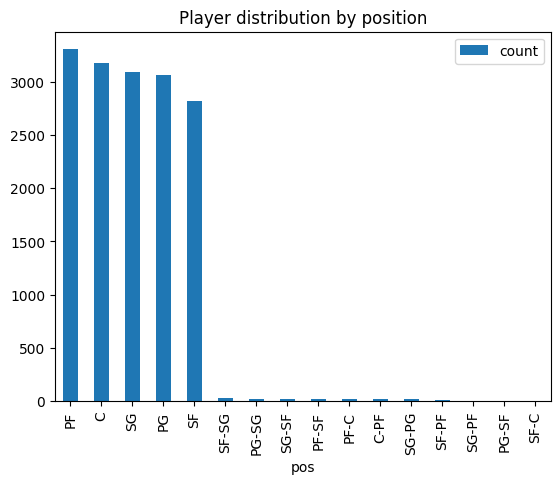

In [222]:
pd.DataFrame(raw_file["pos"].value_counts()).plot.bar(title = "Player distribution by position")

In [223]:
# Pick position that the player plays max
max_pos = raw_file[['pg_percent', 'sg_percent','sf_percent', 'pf_percent','c_percent']].idxmax(axis=1).str.split("_", expand = True).iloc[:,0].str.upper()
raw_file["pos"] = np.where(raw_file["pos"].str.len() > 2, max_pos, raw_file["pos"])
raw_file["pos"].value_counts()

pos
PF    3345
C     3205
SG    3128
PG    3088
SF    2865
Name: count, dtype: int64

Data Cleansing

In [224]:
columns_nas = pd.DataFrame(raw_file.isna().sum().sort_values(ascending=False)).head(15)
columns_nas

,0
birth_year,15451
nba roy_share,15425
nba roy_winner,15425
All-Rookie,15308
All-Defense,15308
smoy_share,15213
smoy_winner,15213
All-NBA,15149
dpoy_winner,15142
dpoy_share,15142


In [225]:
# Drop useless columns at the moment
useless = ["birth_year", "tm", "player", "season", "seas_id", "player_id"]
raw_file = raw_file.drop(columns = useless)

Feature Engineering - on Awards

In [226]:
# Awards + Position
to_binary = ["nba roy_winner", "smoy_winner", "dpoy_winner", "nba mvp_winner", "mip_winner"]
to_multiple_binary = ["All-Rookie", "All-Defense", "All-NBA", "pos"]
drop = ["nba roy_share", "smoy_share", "dpoy_share", "mip_share"]
keep_and_fill_0 = ["nba mvp_share"]

In [227]:
to_multiple_binary_df = pd.get_dummies(raw_file[to_multiple_binary], dtype=float)
to_multiple_binary_df

,All-Rookie_1st,All-Rookie_2nd,All-Defense_1st,All-Defense_2nd,All-NBA_1st,All-NBA_2nd,All-NBA_3rd,pos_C,pos_PF,pos_PG,pos_SF,pos_SG
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
15636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
15637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
15638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
15639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [228]:
for col in to_binary:
    raw_file[col] = raw_file[col].fillna(0).astype(int)

raw_file = pd.concat([raw_file.drop(columns = to_multiple_binary + drop), to_multiple_binary_df], axis=1)
for col in keep_and_fill_0:
    raw_file[col] = raw_file[col].fillna(0)

Feature Cleansing - Temporary drop Stats NA before 1996


In [229]:
missing_col_before_1996 = pd.DataFrame(raw_file.isna().sum())
missing_col_before_1996 = missing_col_before_1996[missing_col_before_1996 == 2533].dropna().index.tolist()
raw_file = raw_file.drop(columns = missing_col_before_1996)

In [230]:
numerical_features = raw_file.select_dtypes(exclude = ["object"]).columns
numerical_features = list(numerical_features.drop("salary"))


Feature Cleansing - Other Columns missing data

In [231]:
fill_with_mean_median = ["f_tr_y", "d_rtg_y", "ft_fga", "orb_percent_y", "tov_percent_y", "e_fg_percent", "ts_percent_y", "x3p_ar_y", 
                  "pace", "n_rtg", "o_rtg_y", "opp_drb_percent", "srs", "sos", "mov", "pl", "pw", "l", "w", "opp_tov_percent", "opp_e_fg_percent", 
                  "opp_ft_fga", "x3p_ar_x", "f_tr_x", "ts_percent_x", "tov_percent_x"]
fill_false = ["playoffs"]

<Axes: title={'center': 'Histrogram: Pace'}, ylabel='Frequency'>

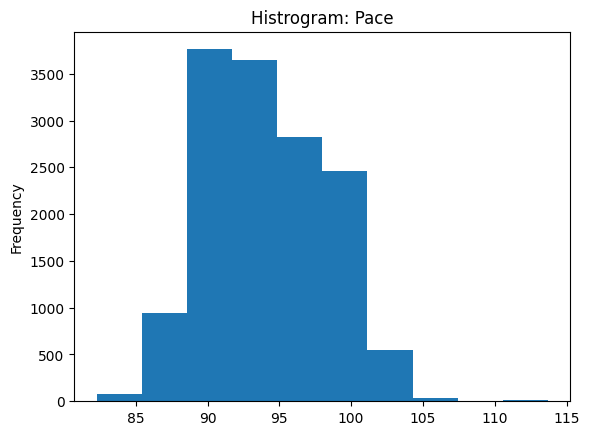

In [232]:
raw_file["pace"].plot.hist(title = "Histrogram: Pace")

<Axes: title={'center': 'Histrogram: f_tr_x'}, ylabel='Frequency'>

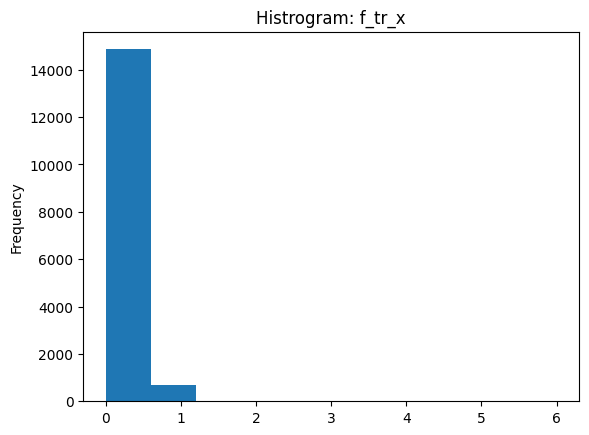

In [233]:
raw_file['f_tr_x'].plot.hist(title = "Histrogram: f_tr_x")

In [234]:
fill_with_mean, fill_with_median = [], []
for col in fill_with_mean_median:
    # Fill with median if large skewness, otherwise fill with mean
    if abs(raw_file[col].skew()) >= 1:
        fill_with_median.append(col)
        raw_file[col] = raw_file[col].fillna(raw_file[col].median())
    else:
        fill_with_mean.append(col)
        raw_file[col] = raw_file[col].fillna(raw_file[col].mean())

for col in fill_false:
    raw_file[col] = raw_file[col].fillna(False).astype(int)

In [235]:
fill_with_median

['f_tr_x', 'ts_percent_x', 'tov_percent_x']

In [236]:
len(fill_with_mean), len(fill_with_median)

(23, 3)

Drop few rows with empty values

In [237]:
print("Before", raw_file.shape)
raw_file = raw_file.dropna()
print("After", raw_file.shape)

Before (15641, 115)
After (15640, 115)


In [238]:
pd.options.display.max_columns=111
raw_file.head()

,age,experience,g,mp,per,ts_percent_x,x3p_ar_x,f_tr_x,orb_percent_x,drb_percent,trb_percent,ast_percent,stl_percent,blk_percent,tov_percent_x,usg_percent,ows,dws,ws,ws_48,obpm,dbpm,bpm,vorp,All Star?,share,x1st_tm,x2nd_tm,x3rd_tm,fg_per_36_min,fga_per_36_min,fg_percent_x,x3p_per_36_min,x3pa_per_36_min,x3p_percent_x,x2p_per_36_min,x2pa_per_36_min,x2p_percent_x,ft_per_36_min,fta_per_36_min,ft_percent_x,orb_per_36_min,drb_per_36_min,trb_per_36_min,ast_per_36_min,stl_per_36_min,blk_per_36_min,tov_per_36_min,pf_per_36_min,pts_per_36_min,fg_per_100_poss,fga_per_100_poss,fg_percent_y,x3p_per_100_poss,x3pa_per_100_poss,...,fta_per_100_poss,ft_percent_y,orb_per_100_poss,drb_per_100_poss,trb_per_100_poss,ast_per_100_poss,stl_per_100_poss,blk_per_100_poss,tov_per_100_poss,pf_per_100_poss,pts_per_100_poss,o_rtg_x,d_rtg_x,dpoy_winner,mip_winner,nba mvp_share,nba mvp_winner,nba roy_winner,smoy_winner,playoffs,w,l,pw,pl,mov,sos,srs,o_rtg_y,d_rtg_y,n_rtg,pace,f_tr_y,x3p_ar_y,ts_percent_y,e_fg_percent,tov_percent_y,orb_percent_y,ft_fga,opp_e_fg_percent,opp_tov_percent,opp_drb_percent,opp_ft_fga,salary,All-Rookie_1st,All-Rookie_2nd,All-Defense_1st,All-Defense_2nd,All-NBA_1st,All-NBA_2nd,All-NBA_3rd,pos_C,pos_PF,pos_PG,pos_SF,pos_SG
0,26,5,82,2709,14.7,0.548,0.057,0.459,11.5,18.4,15.1,4.6,1.2,1.1,10.7,17.1,4.4,3.3,7.7,0.137,0.3,-0.9,-0.6,1.0,1.0,0.0,0,0,0,5.1,10.7,0.478,0.2,0.6,0.283,4.9,10.1,0.489,3.7,4.9,0.751,3.5,6.0,9.5,1.2,0.9,0.7,1.5,2.8,14.1,7.1,14.8,0.478,0.2,0.8,...,6.8,0.751,4.8,8.3,13.1,1.7,1.2,0.9,2.1,3.8,19.5,116,107,0,0,0.0,0,0,0,1,63.0,19.0,58.0,24.0,6.78,-0.04,6.74,114.0,107.0,7.0,96.3,0.345,0.120,0.562,0.512,13.2,32.8,0.271,0.479,12.8,68.5,0.219,4110398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,23,1,51,331,9.5,0.549,0.000,0.368,11.7,22.9,17.4,2.8,1.6,3.2,26.6,14.8,-0.3,0.7,0.4,0.061,-5.3,1.4,-4.0,-0.2,0.0,0.0,0,0,0,4.6,8.3,0.553,0.0,0.0,0.000,4.6,8.3,0.553,1.4,3.0,0.464,3.9,7.9,11.9,0.8,1.2,2.0,3.5,7.5,10.5,6.0,10.9,0.553,0.0,0.0,...,4.0,0.464,5.2,10.5,15.6,1.0,1.6,2.6,4.6,9.9,13.9,91,100,0,0,0.0,0,0,0,1,41.0,41.0,45.0,37.0,1.46,0.24,1.71,104.8,103.4,1.4,101.2,0.313,0.068,0.531,0.491,15.5,33.1,0.225,0.475,14.7,69.2,0.228,645919.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,34,14,45,1300,15.4,0.556,0.004,0.525,6.9,8.1,7.5,9.6,0.8,0.3,11.2,22.6,2.2,0.8,3.1,0.113,0.9,-1.4,-0.4,0.5,0.0,0.0,0,0,0,6.4,13.4,0.477,0.0,0.1,0.000,6.4,13.3,0.479,5.5,7.0,0.787,2.2,2.6,4.8,2.2,0.6,0.2,2.1,2.7,18.3,9.0,18.9,0.477,0.0,0.1,...,9.9,0.787,3.0,3.7,6.7,3.1,0.8,0.3,2.9,3.9,25.9,113,112,0,0,0.0,0,0,0,1,47.0,35.0,41.0,41.0,0.07,0.35,0.42,107.2,107.2,0.0,94.5,0.331,0.071,0.536,0.487,13.6,30.3,0.254,0.481,13.4,67.9,0.232,939519.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,36,14,80,2211,17.9,0.522,0.004,0.142,5.3,8.4,6.8,15.6,1.1,0.6,6.3,26.0,3.3,1.7,5.1,0.110,2.5,-1.2,1.2,1.8,0.0,0.0,0,0,0,10.3,21.1,0.491,0.0,0.1,0.400,10.3,21.0,0.491,2.6,3.0,0.880,1.9,2.7,4.7,3.7,0.8,0.4,1.5,2.1,23.3,13.1,26.6,0.491,0.0,0.1,...,3.8,0.880,2.5,3.4,5.9,4.6,1.1,0.5,1.9,2.7,29.5,110,110,0,0,0.0,0,0,0,1,43.0,39.0,45.0,37.0,1.41,0.15,1.56,108.0,106.7,1.3,105.4,0.275,0.084,0.523,0.478,11.2,29.1,0.217,0.501,15.2,71.3,0.264,3523198.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,25,1,72,937,11.9,0.530,0.120,0.423,6.2,8.5,7.3,12.3,1.9,1.4,13.4,17.4,1.0,0.4,1.4,0.074,-1.3,0.1,-1.2,0.2,0.0,0.0,0,0,0,5.3,10.9,0.482,0.5,1.3,0.382,4.8,9.6,0.496,2.7,4.6,0.583,2.0,2.6,4.6,3.2,1.4,0.8,2.0,6.4,13.7,7.3,15.2,0.482,0.7,1.8,...,6.4,0.583,2.8,3.6,6.4,4.4,1.9,1.2,2.8,8.9,19.1,110,113,0,0,0.0,0,0,0,0,41.0,41.0,44.0,38.0,1.02,-0.39,0.64,113.0,111.9,1.1,95.8,0.362,0.059,0.547,0.496,13.5,36.3,0.277,0.509,14.0,65.5,0.254,1526719.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Y: Salary is highly skewed => transform that

2.191767147772739
5.658145814554576


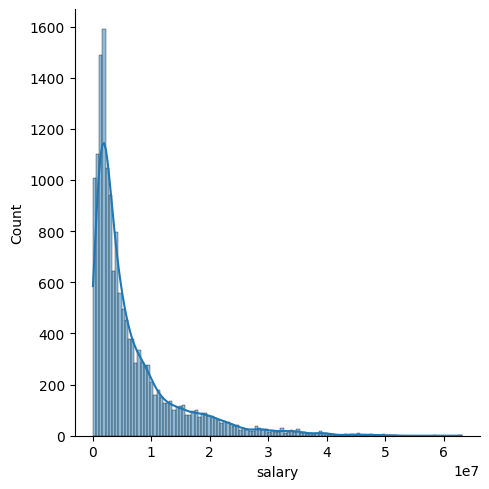

In [239]:
seaborn.displot(raw_file, x="salary", kde=True)
print(raw_file["salary"].skew())
print(raw_file["salary"].kurtosis())


In [240]:
raw_file["salary"] = np.log(raw_file["salary"])

AttributeError: Rectangle.set() got an unexpected keyword argument 'title'

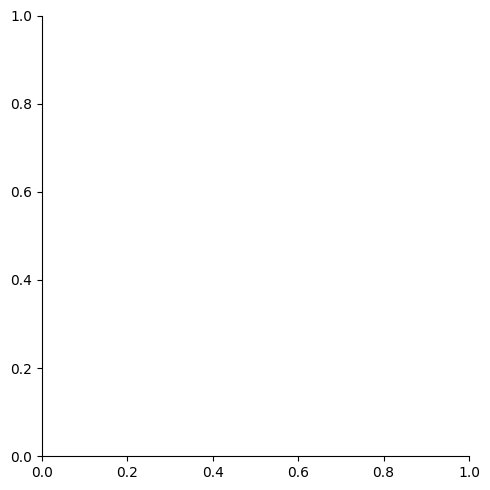

In [241]:
seaborn.displot(raw_file, x="salary", kde=True)

Data Modelling

Model 1: Simple Linear Regression

In [ ]:
X = raw_file.drop(columns = ["salary"])
Y = raw_file["salary"]
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.3, random_state=0)

In [ ]:
model_1 = LinearRegression().fit(X_train, Y_train)
pred_1 = model_1.predict(X_valid)

In [ ]:
mse_1 = mean_squared_error(y_true=Y_valid, y_pred=pred_1)
rmse_1 = np.sqrt(mse_1)
print(rmse_1)

0.8460486235462261


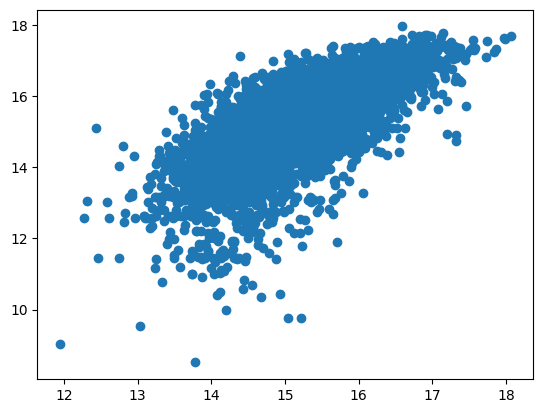

In [ ]:
plt.scatter(pred_1, Y_valid)

Model 2: Decision Tree Regressor

In [ ]:
model_2 = DecisionTreeRegressor().fit(X = X_train, y = Y_train)
pred_2 = model_2.predict(X_valid)

In [ ]:
mse_2 = mean_squared_error(y_true=Y_valid, y_pred=pred_2)
rmse_2 = np.sqrt(mse_2)
print(rmse_2)

1.1247380622703684


Model 3: Lasso Regressor

In [ ]:
model_3 = LassoCV(eps = 0.01, n_alphas = 1000,cv=5).fit(X = X_train, y = Y_train)
score = cross_val_score(model_3, X_train, Y_train, scoring="neg_root_mean_squared_error")


In [ ]:
pred_3 = model_3.predict(X_valid)
mse_3 = mean_squared_error(y_true=Y_valid, y_pred=pred_3)
rmse_3 = np.sqrt(mse_3)
print(rmse_3)

1.013382291347592
